In [2]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_train_loader
from detectron2.data.datasets import register_coco_instances
from detectron2.data import DatasetMapper, transforms as T
from detectron2.utils.visualizer import Visualizer
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.model_zoo import get_checkpoint_url
from detectron2 import model_zoo

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def register_dataset(dataset_name, image_dir, annotation_path):
    register_coco_instances(dataset_name, {}, annotation_path, image_dir)

In [4]:
def visualize_dataset(dataset_name, metadata, num_samples=3):
    dataset_dicts = DatasetCatalog.get(dataset_name)
    for data in random.sample(dataset_dicts, num_samples):
        img = cv2.imread(data["file_name"])
        visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.5)
        vis = visualizer.draw_dataset_dict(data)
        plt.figure(figsize=(12, 8))
        plt.imshow(vis.get_image()[:, :, ::-1])
        plt.axis("off")
        plt.show()


In [ ]:
def apply_augmentations_with_masks_and_boxes(dataset_dicts, metadata, num_samples=3):
    augmentations = [
        T.RandomFlip(prob=0.5, horizontal=True, vertical=False),
        T.RandomRotation(angle=[0, 90, 180, 270]),
        T.RandomBrightness(0.8, 1.2),
        T.RandomContrast(0.8, 1.2),
    ]

    for data in random.sample(dataset_dicts, num_samples):
        img = cv2.imread(data["file_name"])
        aug_input = T.AugInput(img)
        transforms = T.AugmentationList(augmentations)(aug_input)
        img_aug = aug_input.image  # Augmented image

        # Apply transforms to segmentation masks
        for ann in data["annotations"]:
            if "segmentation" in ann:
                new_segmentation = []
                for poly in ann["segmentation"]:
                    poly_np = np.array(poly).reshape(-1, 2)  # Convert to NumPy array
                    transformed_poly = transforms.apply_coords(poly_np)
                    new_segmentation.append(transformed_poly.flatten().tolist())  # Flatten back to list
                ann["segmentation"] = new_segmentation

                # Recalculate bounding box
                all_x = [p[0] for p in transformed_poly]
                all_y = [p[1] for p in transformed_poly]
                x_min, y_min = min(all_x), min(all_y)
                x_max, y_max = max(all_x), max(all_y)
                ann["bbox"] = [x_min, y_min, x_max - x_min, y_max - y_min]

        # Debug
        print("Updated Bounding Box:", data["annotations"][0].get("bbox"))

        # Visualize augmented image and transformed annotations
        visualizer = Visualizer(img_aug[:, :, ::-1], metadata=metadata, scale=0.5)
        vis = visualizer.draw_dataset_dict(data)
        plt.figure(figsize=(12, 8))
        plt.imshow(vis.get_image()[:, :, ::-1])
        plt.axis("off")
        plt.show()

In [6]:
def get_augmented_loader(cfg):
    mapper = DatasetMapper(is_train=True, augmentations=[
        T.RandomFlip(prob=0.5, horizontal=True, vertical=False),
        T.RandomRotation(angle=[0, 90, 180, 270]),
        T.RandomBrightness(0.8, 1.2),
        T.RandomContrast(0.8, 1.2),
    ])
    return build_detection_train_loader(cfg, mapper=mapper)

In [7]:
class AugmentedTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        return get_augmented_loader(cfg)

In [ ]:
def configure_model():
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x")

    cfg.DATASETS.TRAIN = ("paddy_train",)
    cfg.DATASETS.TEST = ()
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  
    cfg.SOLVER.IMS_PER_BATCH = 2
    cfg.SOLVER.BASE_LR = 0.00025
    cfg.SOLVER.MAX_ITER = 3000  
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
    cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.3
    cfg.MODEL.ROI_HEADS.PRE_NMS_TOPK_TEST = 1000

    # Ensure TPU support
    cfg.MODEL.DEVICE = 'xla'  

    return cfg

In [ ]:
def get_dataset_mapper(cfg):
    mapper = DatasetMapper(cfg, is_train=True, image_format="RGB")
    return mapper

In [9]:
def train_model(cfg, output_dir):
    cfg.OUTPUT_DIR = output_dir
    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
    trainer = AugmentedTrainer(cfg)
    trainer.build_hooks = get_dataset_mapper(cfg)
    trainer.resume_or_load(resume=False)
    trainer.train()

Visualizing raw dataset...


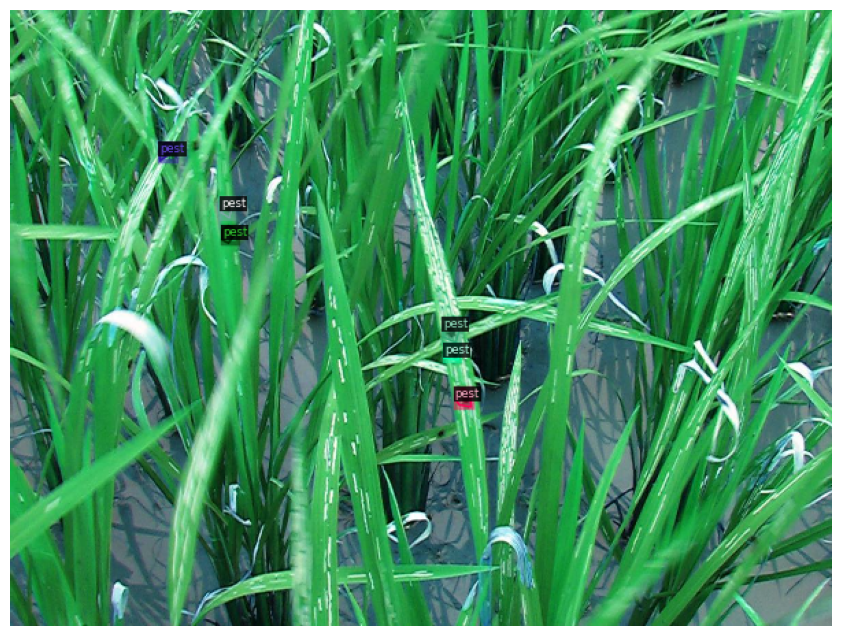

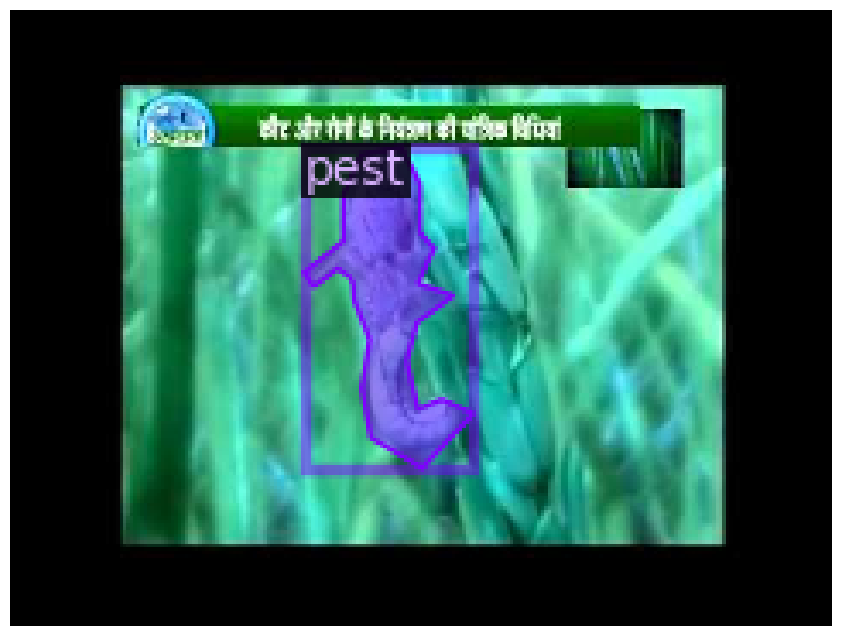

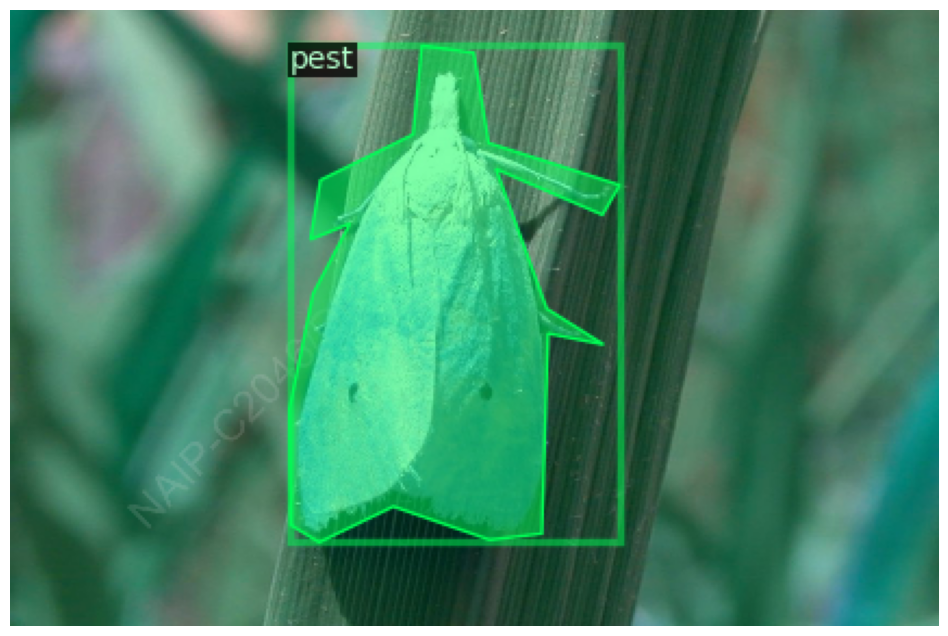

Visualizing augmented dataset with corrected bounding boxes...
Updated Bounding Box: [293.08964556453, 242.10943246173215, 185.85586008676677, 143.61684928985412]


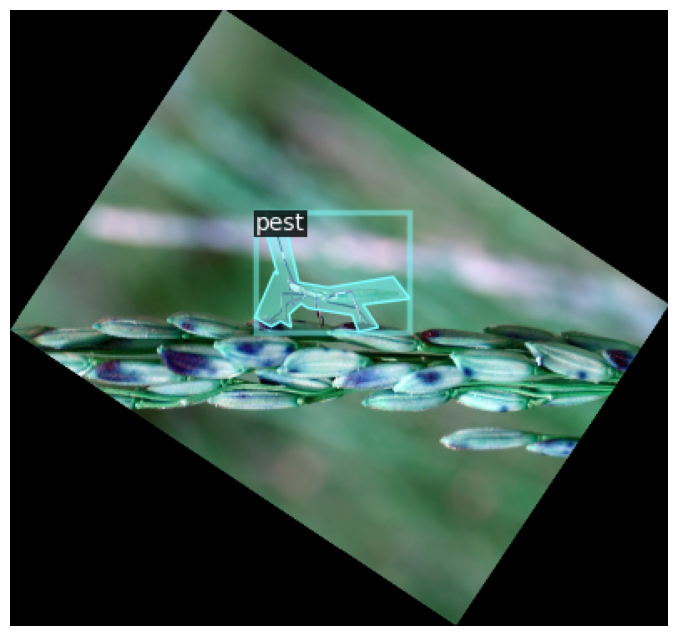

Updated Bounding Box: [336.309367929135, 584.570939938639, 379.5352666425841, 224.2751284224588]


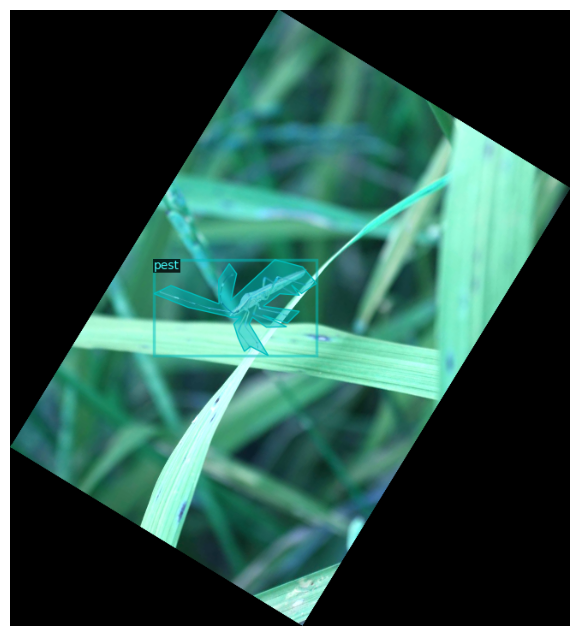

Updated Bounding Box: [82.82188739513984, 61.7309712832994, 94.80351070184261, 74.06761883767209]


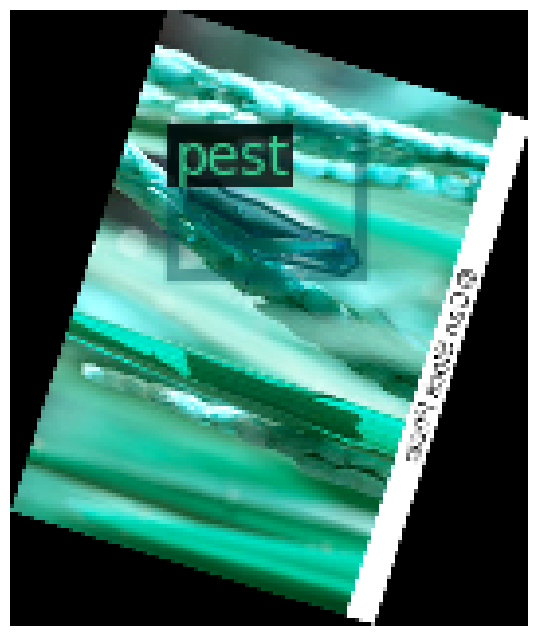

In [ ]:
if __name__ == "__main__":
    
    dataset_name = "paddy_train"
    image_dir = "/content/drive/MyDrive/aa/images"  
    annotation_path = "/content/drive/MyDrive/aa/combined.json"  

    # Register dataset
    register_dataset(dataset_name, image_dir, annotation_path)
    metadata = MetadataCatalog.get(dataset_name)

    
    print("Visualizing raw dataset...")
    visualize_dataset(dataset_name, metadata)

    
    print("Visualizing augmented dataset with corrected bounding boxes...")
    dataset_dicts = DatasetCatalog.get(dataset_name)
    apply_augmentations_with_masks_and_boxes(dataset_dicts, metadata)

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))

cfg.DATASETS.TRAIN = ("paddy_train",)
cfg.DATASETS.TEST = ()
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 3000  

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.3
cfg.MODEL.ROI_HEADS.PRE_NMS_TOPK_TEST = 1000
cfg.MODEL.ROI_HEADS.CLS_WEIGHT = 10.0  
cfg.MODEL.ROI_HEADS.BBOX_WEIGHT = 1.0

# cfg.MODEL.DEVICE = 'xla'  


trainer = DefaultTrainer(cfg)
trainer.build_hooks = get_dataset_mapper(cfg)  

trainer.resume_or_load(resume=False)


trainer.train()

[12/31 13:03:14 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
R-50.pkl: 102MB [00:00, 174MB/s]                            


[12/31 13:03:15 d2.checkpoint.c2_model_loading]: Renaming Caffe2 weights ......
[12/31 13:03:15 d2.checkpoint.c2_model_loading]: Following weights matched with submodule backbone.bottom_up - Total num: 54


backbone.fpn_lateral2.{bias, weight}
backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output2.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_head.fc1.{bias, weight}
roi_heads.box_head.fc2.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.deconv.{bias, weight}
roi_heads.mask_head.mask_fcn1.{bias, weight}
roi_heads.mask_head.mask_fcn2.{bias, weight}
roi_heads.mask_head.mask_fcn3.{bias, weight}
roi_heads.mask_head.mask_fcn4.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}
  fc1000.{bias, weight}
  stem.conv1.bias


[12/31 13:03:15 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[12/31 13:03:30 d2.utils.events]:  eta: 0:21:04  iter: 19  total_loss: 2.233  loss_cls: 0.7743  loss_box_reg: 0.009501  loss_mask: 0.6924  loss_rpn_cls: 0.7008  loss_rpn_loc: 0.01228    time: 0.4339  last_time: 0.4232  data_time: 0.0673  last_data_time: 0.0138   lr: 4.9953e-06  max_mem: 2669M
[12/31 13:03:44 d2.utils.events]:  eta: 0:21:10  iter: 39  total_loss: 1.748  loss_cls: 0.341  loss_box_reg: 0.001025  loss_mask: 0.6926  loss_rpn_cls: 0.6927  loss_rpn_loc: 0.01396    time: 0.4447  last_time: 0.4001  data_time: 0.0392  last_data_time: 0.0074   lr: 9.9902e-06  max_mem: 2669M
[12/31 13:03:54 d2.utils.events]:  eta: 0:20:57  iter: 59  total_loss: 1.514  loss_cls: 0.108  loss_box_reg: 0.01793  loss_mask: 0.6907  loss_rpn_cls: 0.6735  loss_rpn_loc: 0.02128    time: 0.4527  last_time: 0.4061  data_time: 0.0403  last_data_time: 0.0020   lr: 1.4985e-05  max_mem: 2669M
[12/31 13:04:02 d2.utils.events]:  eta: 0:21:00  iter: 79  total_loss: 1.452  loss_cls: 0.07719  loss_box_reg: 0.02195  l

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader


cfg.DATASETS.TEST = ("paddy_train",)  
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "/content/output/model_final.pth")

evaluator = COCOEvaluator("paddy_train", cfg, False, output_dir="./output")
val_loader = build_detection_test_loader(cfg, "paddy_train")
print(inference_on_dataset(trainer.model, val_loader, evaluator))


WARNING [12/31 13:35:54 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[12/31 13:35:54 d2.data.datasets.coco]: Loaded 117 images in COCO format from /content/drive/MyDrive/aa/combined.json
[12/31 13:35:54 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[12/31 13:35:54 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[12/31 13:35:54 d2.data.common]: Serializing 117 elements to byte tensors and concatenating them all ...
[12/31 13:35:54 d2.data.common]: Serialized dataset takes 0.14 MiB
[12/31 13:35:54 d2.evaluation.evaluator]: Start inference on 117 batches


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[12/31 13:35:59 d2.evaluation.evaluator]: Inference done 11/117. Dataloading: 0.0110 s/iter. Inference: 0.1604 s/iter. Eval: 0.0030 s/iter. Total: 0.1743 s/iter. ETA=0:00:18
[12/31 13:36:04 d2.evaluation.evaluator]: Inference done 43/117. Dataloading: 0.0224 s/iter. Inference: 0.1303 s/iter. Eval: 0.0064 s/iter. Total: 0.1595 s/iter. ETA=0:00:11
[12/31 13:36:09 d2.evaluation.evaluator]: Inference done 77/117. Dataloading: 0.0150 s/iter. Inference: 0.1252 s/iter. Eval: 0.0134 s/iter. Total: 0.1539 s/iter. ETA=0:00:06
[12/31 13:36:15 d2.evaluation.evaluator]: Inference done 108/117. Dataloading: 0.0189 s/iter. Inference: 0.1264 s/iter. Eval: 0.0135 s/iter. Total: 0.1591 s/iter. ETA=0:00:01
[12/31 13:36:16 d2.evaluation.evaluator]: Total inference time: 0:00:17.653551 (0.157621 s / iter per device, on 1 devices)
[12/31 13:36:16 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:14 (0.125515 s / iter per device, on 1 devices)
[12/31 13:36:16 d2.evaluation.coco_evaluation]: P

[12/31 13:42:33 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

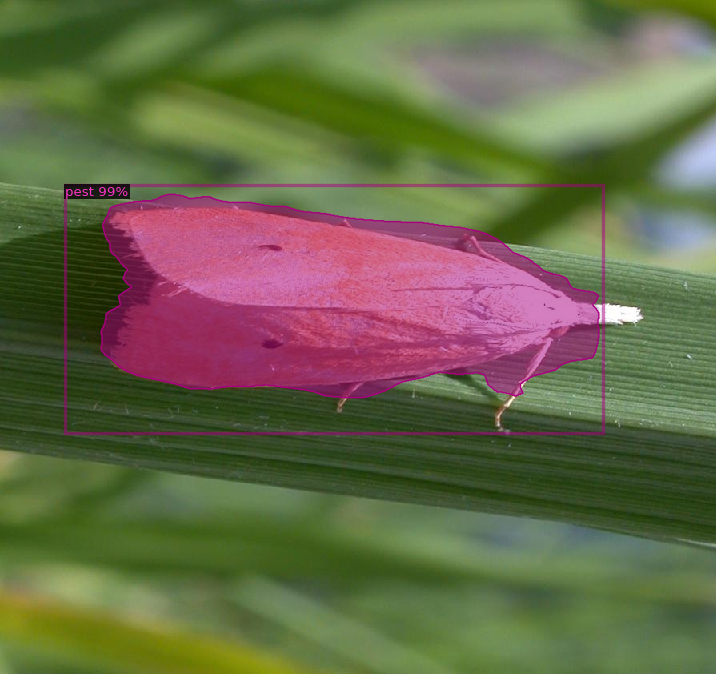

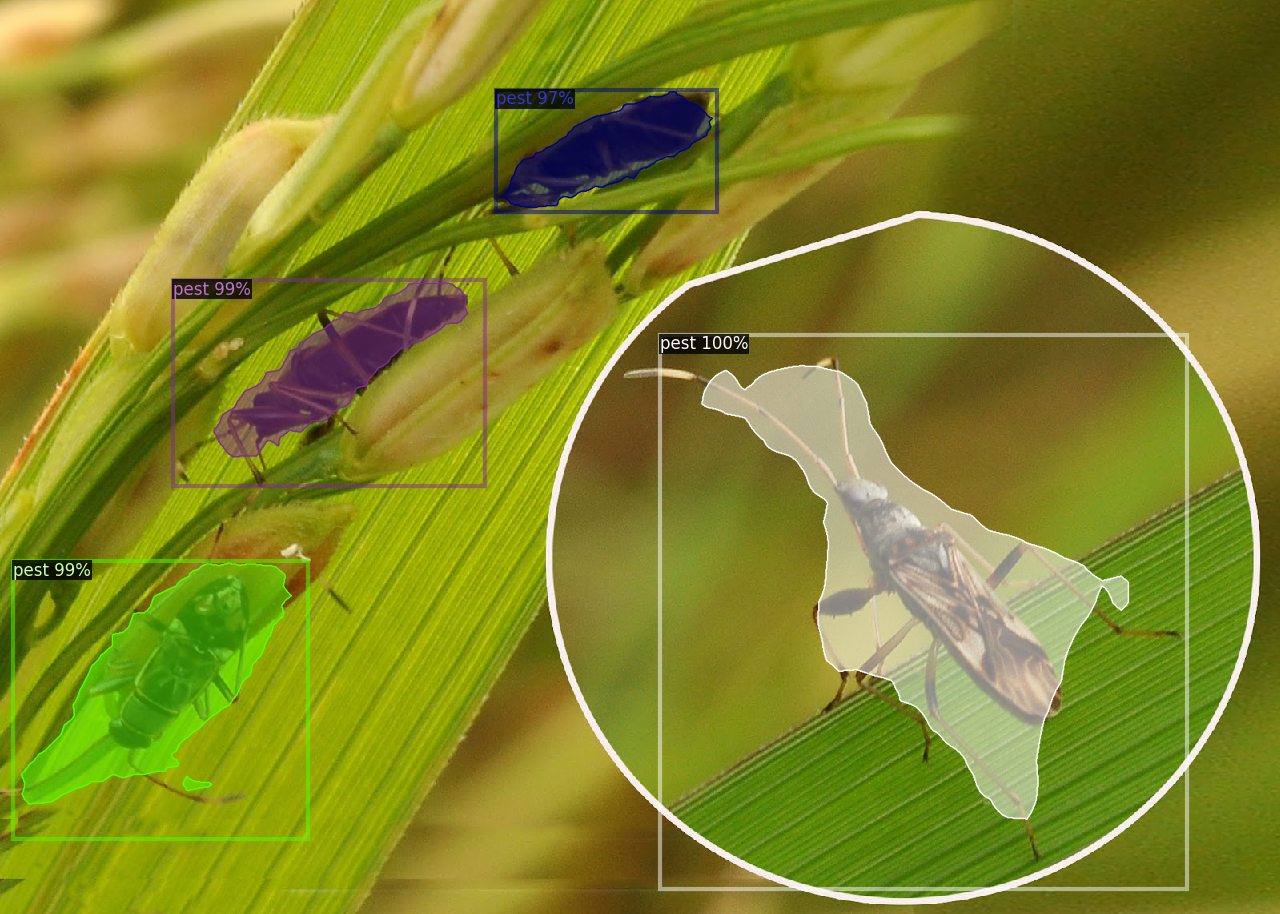

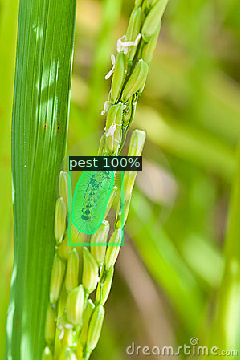

In [ ]:
from detectron2.utils.visualizer import ColorMode
from detectron2.engine import DefaultPredictor
from google.colab.patches import cv2_imshow  

# Load a sample image
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  

predictor = DefaultPredictor(cfg)

for d in dataset_dicts[:3]:
    img = cv2.imread(d["file_name"])
    outputs = predictor(img)

    # Visualize predictions
    v = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.8, instance_mode=ColorMode.SEGMENTATION)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    cv2_imshow(v.get_image()[:, :, ::-1])  
    cv2.waitKey(0)  


Saving images (1).jpeg to images (1).jpeg


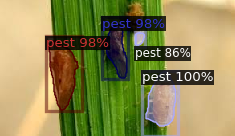

In [ ]:
# This allows you to upload files from your local machine
from google.colab import files

def upload_image():
    uploaded = files.upload()  
    for fn in uploaded.keys():
        return fn  

image_path = upload_image()
img = cv2.imread(image_path)

# Run inference on the custom image
outputs = predictor(img)

# Visualize predictions
v = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.8, instance_mode=ColorMode.SEGMENTATION)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))

# Display the predicted image
cv2_imshow(v.get_image()[:, :, ::-1])

In [ ]:
import torch
torch.save(trainer.model.state_dict(), "/content/drive/MyDrive/aa/mask_rcnn_paddy.pth")